In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from datasets import load_dataset, load_metric

from huggingface_hub import notebook_login

notebook_login()

In [5]:
datasets = load_dataset("tweet_eval", "sentiment")

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
print(datasets["train"]["text"][:5])
print(datasets["train"]["label"][:5])

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.', "Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays", '@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"']
[2, 1, 1, 1, 2]


## Vectorize

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(datasets["train"]["text"])
vectors_test = vectorizer.transform(datasets["test"]["text"])
print(vectors_train.shape, vectors_test.shape)

(45615, 43358) (12284, 43358)


Here we see the tupple (num__documents, num_features)
- num__documents represent the number of documents available in that dataset, in our case number of tweets
- num_features represent the number of unique words in the vocabulary learned by the vectorizer, in our case 43358 unique words are in the vocabulary

Lets analyze the vocabulary for each label.

In [ ]:
import numpy as np
# Get the feature names (words) from the vocabulary
feature_names = vectorizer.get_feature_names()

# Define labels and their associated documents
labels = [0, 1, 2]  # Labels: 0 = negative, 1 = neutral, 2 = positive
documents_by_label = {label: [] for label in labels}
for text, label in zip(datasets["train"]["text"], datasets["train"]["label"]):
    documents_by_label[label].append(text)

# Print the top scored words for each label
num_top_words = 5  # Number of top words to print
for label in labels:
    print(f"Top {num_top_words} words for label {label}:")
    label_vectors = vectors_train[np.array(datasets["train"]["label"]) == label]
    label_indices = np.argsort(label_vectors.toarray().sum(axis=0))[-num_top_words:]
    top_words = [feature_names[idx] for idx in label_indices]
    print(top_words)
    print()

c:\Users\shwet\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 5 words for label 0:
['and', 'is', 'user', 'to', 'the']

Top 5 words for label 1:
['on', 'in', 'user', 'to', 'the']

Top 5 words for label 2:
['on', 'and', 'user', 'to', 'the']



In [ ]:
print("\n".join(vectorizer.get_feature_names()[:20]))

00
000
0001
000758
000th
001
0048
007
00am
00end
00p
00pm
01
0118704263
01253625262
01792
01924
01937
01943
01pm


##  Vectorize test and classify

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

def classify(model):
     clf = model
     clf.fit(vectors_train, datasets["train"]["label"])
     pred = clf.predict(vectors_test)
     print(metrics.f1_score(datasets["test"]["label"], pred, average='macro'),
          metrics.accuracy_score(datasets["test"]["label"], pred))
     cm = metrics.confusion_matrix(datasets["test"]["label"], pred)
     print (cm)

     return clf, pred, cm

nb, pred, cm = classify(MultinomialNB(alpha=0.1))

0.5305923702116752 0.5584500162813416
[[1436 2187  349]
 [ 724 4136 1077]
 [  89  998 1288]]


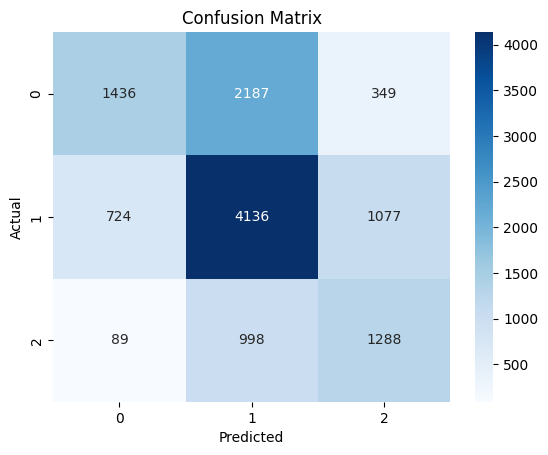

In [8]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set plot labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [21]:
import numpy as np
import random
from IPython.display import display

# Gather misclassified samples
def get_misclassified_samples(y_pred, y):
    misclassified_samples = []

    for i in range(len(y_pred)):
        if y_pred[i] != y[i]:

            # Append tupple of index of error, predicted and real values
            misclassified_samples.append((i, y_pred[i], y[i]))

    return misclassified_samples

def get_random_samples(data, number):
    random_elements_list = []
    random_elements = random.sample(data, number)
    for element in random_elements:
        random_elements_list.append(element)

    return random_elements_list



label_translator = {
    0: "negative",
    1: "neutral",
    2: "positive",
}

def print_error(index, pred):
    display(datasets["test"]["text"][index])
    print(f"index: {index}")
    print(f"predicted value: {label_translator[pred[index]]}")
    print(f"real value: {label_translator[datasets['test']['label'][index]]}\n")

In [10]:
misclassified_samples = get_misclassified_samples(pred, datasets["test"]["label"])
random_missclassified_samples = get_random_samples(misclassified_samples, 20)
random_missclassified_samples[0][0]

7125

In [ ]:
for i in range(len(random_missclassified_samples)):
    print_error(random_missclassified_samples[i][0])

'By 2025, #robotics and #drones, together, could replace 1/3 of the current global #workforce. #robots @user'

index: 8791
predicted value: negative
real value: neutral



'@user @user @user I can c his point anti trump people may start small riots around the country FBI should b the ones'

index: 9888
predicted value: neutral
real value: negative



'FastBigBowie& PunchAction NotQuickest #HAMAS BegsToBeDestroyedSameAs #ISIS VIVA! Samson! #Israel #IStandWithIsrael !'

index: 9685
predicted value: negative
real value: neutral



"@user Nah, she's cool. Repeal won't kick in before summer, when she's old enough for Medicare. Oh, wait..."

index: 12220
predicted value: positive
real value: neutral



"#TrumpTransitionTeam It's not a government, it's a movement #RightWingRevolution #Fascism"

index: 5589
predicted value: neutral
real value: negative



'You should b ashamed JILL STEIN, u are in the tank w George Soros & Hillary Clinton, go to hell..'

index: 3251
predicted value: neutral
real value: negative



"Thx 4 Folow'ng @user This from #Jerusalem - a #contemporary take on prayer beads #art #culture…"

index: 8298
predicted value: neutral
real value: positive



"Luke Kennard done turned into our best player. He's having that last season Grayson Allen breakout"

index: 2683
predicted value: neutral
real value: positive



'Leo Messi delivered 59 completed passes in Glsagow. More stats like this here: #FCBlive'

index: 8202
predicted value: positive
real value: neutral



'When will #Amerikkka wake up ?Before their#SocialSecurity#Medicare#Medicaid#AbortionRightsare tossed asideby the #Trumpand the #GOP'

index: 4275
predicted value: neutral
real value: negative



'5 Incidents of How Zac Efron Is Inspirational'

index: 12094
predicted value: negative
real value: neutral



"I'd believe more in self-driving cars if there were a single Map program that didn't frequently catastrophically malfunction"

index: 7961
predicted value: positive
real value: negative



"Bullet for my valentines on the mix, it's good to be back, damn."

index: 1551
predicted value: neutral
real value: positive



'Cannabis For Kids: The Children Behind The Debate (FULL DOCUMENTARY)'

index: 7980
predicted value: positive
real value: neutral



'Im glad that gay marriage is now legal, just have to figure out how to force chance the rapper to marry me!!'

index: 3442
predicted value: neutral
real value: positive



"@user @user take care of that lil illegal immigration problem too.  They'll stay home/they'll go home.   jobs will do that."

index: 6102
predicted value: neutral
real value: negative



'#Facebook gives #Hamas bandit the boot; Shuts their accounts down'

index: 2088
predicted value: neutral
real value: negative



"What is life lol what are we 💀😂 UFO's steal our cows bc they like beef to 😂 f vegetarianism that's what's the aliens want you to be 👽😂"

index: 6482
predicted value: neutral
real value: negative



"@user If the popular vote counted at all we wouldn't be having this conversation. Trump won. He's a jerk, but he did win."

index: 792
predicted value: positive
real value: neutral



'When watching a David Blaine special, @user and dorrajarrod attempt to make magic'

index: 7710
predicted value: neutral
real value: positive



Since Naive Bayes is a simple and efficient classifier, it may not capture complex relationships between features. That is why we procceed with another classifier.

## SVM

In [7]:
from sklearn import metrics
from sklearn.svm import LinearSVC
svm_classifier = LinearSVC()

svm_classifier.fit(vectors_train, datasets["train"]["label"])
svm_predictions = svm_classifier.predict(vectors_test)
f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)

# Print evaluation metrics and confusion matrix
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)

F1 Score: 0.5606065148362993
Accuracy: 0.5748127645718007
Confusion Matrix:
[[1815 1742  415]
 [ 995 3799 1143]
 [ 138  790 1447]]


In [16]:
# print 15 random missclassified examples
misclassified_samples = get_misclassified_samples(svm_predictions, datasets["test"]["label"])
random_missclassified_samples = get_random_samples(misclassified_samples, 15)
for i in range(len(random_missclassified_samples)):
    print_error(random_missclassified_samples[i][0], svm_predictions)

"Venezuela's President Maduro accuses US of fabricating drug case against 2 nephews of first lady..."

index: 8724
predicted value: neutral
real value: negative



'@user @user Call Dir. Comey also!  Ya know, that FBI guy?  I hear he can check for dead voters.  @user @user'

index: 4061
predicted value: neutral
real value: negative



'[SocJus] Conservatives are not allowed to be gay. More doublethink, double standards...'

index: 11476
predicted value: neutral
real value: negative



'@user human rights need to be at the top of the negotiations. End the death penalty for apostates and blasphemy.'

index: 2926
predicted value: negative
real value: neutral



'@user I was responding to "Do better, be better". This year I thnk she deviated fm that. Will read fm library, tks tho. @user'

index: 9608
predicted value: positive
real value: neutral



"@user @user @user @user And Israel has universal healthcare & abortion. We pay. Where's the #Prolife voice?"

index: 7694
predicted value: negative
real value: neutral



'#TheWalkingDead S7 is not very addictive.'

index: 8524
predicted value: neutral
real value: negative



'lmao at all the libs who are worried about whats gonna happen to gun control... my dudes we are way past that level of effete value signals'

index: 813
predicted value: negative
real value: neutral



'Pics from @user on the Interview by #HollywoodLivetoday about #Homewalk and more! #ThisIsUs'

index: 2437
predicted value: neutral
real value: positive



'its always valentines with this one #BabySelcaDay'

index: 337
predicted value: positive
real value: neutral



"Told her don't come for me because she wouldn't be able to find me!!! #IAmTheTruth"

index: 2563
predicted value: negative
real value: neutral



'How to connect your work to the sustainable development goals #SDGs #unitednations #civilsociety #socialsector'

index: 9430
predicted value: positive
real value: neutral



"@user watch that new david blaine show. shits nuts. you won't regret it."

index: 6238
predicted value: negative
real value: neutral



'@user @user come to my lightning talk "deep learning with R" at the next LA R meetup and see'

index: 1609
predicted value: positive
real value: neutral



"ALL my niggas get cheese Tim duncan can't switch teams"

index: 9032
predicted value: positive
real value: neutral



The model does not recognize context. That makes sense, since while pre processing the text we tokenized each word seperately, therefore losing any context of the surrounding words. So for example for index 2926 even though the information conveyed is neutral, the words themselves (especially death, penalty, apostates, and blasphemy) might appear more relevant for the "negative" label.

One way to attack this issue is to give more context for each word. We can do this using n-grams.

## N-Grams

To give each word context, we will use an n-gram range of 1-5. That means features will be created for individual words aswell as n combinations of surrounding words (up to 5).

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,5))
vectors_train = vectorizer.fit_transform(datasets["train"]["text"])
vectors_test = vectorizer.transform(datasets["test"]["text"])
print(vectors_train.shape, vectors_test.shape)

(45615, 2290797) (12284, 2290797)


Here you can see the larger amount of features created by this vectorizer.

In [35]:
# Train the SVM classifier
svm_classifier.fit(vectors_train, datasets["train"]["label"])

svm_predictions = svm_classifier.predict(vectors_test)

f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)


print("F1 Score:", f1_score)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)

F1 Score: 0.5701920332711593
Accuracy: 0.5809182676652557
Confusion Matrix:
[[1830 1617  525]
 [ 970 3684 1283]
 [ 119  634 1622]]


The model with n-grams has gotten a little better. Using our example from before we can see, that with the context of the neighbored words the tweet is correctly classified as neutral.

In [44]:
print_error(2926, svm_predictions)

'@user human rights need to be at the top of the negotiations. End the death penalty for apostates and blasphemy.'

index: 2926
predicted value: neutral
real value: neutral



In [37]:
# print 15 random missclassified examples
misclassified_samples = get_misclassified_samples(svm_predictions, datasets["test"]["label"])
random_missclassified_samples = get_random_samples(misclassified_samples, 15)
for i in range(len(random_missclassified_samples)):
    print_error(random_missclassified_samples[i][0], svm_predictions)

"LIAAAAAM OMG!!  🔥🔥🔥I JIST CAN'T.. I'M LOSING MY SHIT HERE OHSSKXVSJSB#LiamPayne #OneDirection #1D…"

index: 4201
predicted value: negative
real value: positive



'More on "voter suppression operations" and "Facebook dark posts".'

index: 7914
predicted value: neutral
real value: negative



'KIM FATTY THE THIRD'

index: 1601
predicted value: neutral
real value: negative



"@user #Obama #Trump #love #Hillary #Bernie this is what's going on in the Obama Admin continue with Hillary…"

index: 6923
predicted value: positive
real value: neutral



'The latest #NoTPP Today (https://t.co/vd7t22SVe7)! Thanks to @user @user @user #stoptpp #tpp'

index: 12181
predicted value: positive
real value: neutral



"Here's the label for the Bob Dylan countdown's song 17, Mozambique."

index: 2147
predicted value: positive
real value: neutral



"With picks of Steve Bannon & Micheal Flynn, @user unpopular win radically alters Obama's post-presidency plans via @user"

index: 11270
predicted value: neutral
real value: negative



'I tell them the media & Obama admin fought for years to normalize leftism/socialism/communism..so their perception…'

index: 1813
predicted value: negative
real value: neutral



'we are in dangerous days, when the far right wing gains such a prominent and powerful position:  "...“Many of...'

index: 2632
predicted value: neutral
real value: negative



"1.  Emily Gilmore2.  Sookie3.  Lane's mother4.  Miss Patty #GilmoreGirlsTop4"

index: 446
predicted value: positive
real value: neutral



'@user Donald J. Trump, the second president in 20 years to lose the popular vote, most unpopular president in history'

index: 8447
predicted value: neutral
real value: negative



"I'm cool with recount, imagine mud in dems eyes when Trump STILL wins lol"

index: 11684
predicted value: positive
real value: neutral



"@user @user Flowers could have hit .240/.295/.360, and they're selling still but Sale has a Cy Young award"

index: 11960
predicted value: negative
real value: neutral



'@user @user Worse - look at her interview. "Civil Disobedience" sounds like Michael Moore! She calls Trump…'

index: 8782
predicted value: neutral
real value: negative



"'Absurd & Evidence Free' (Polite way of saying Pack of Lies) - #Iran Rejects #Israel Claim of Arms for #Hezbollah on Commercial Flights"

index: 11996
predicted value: negative
real value: neutral



It is also visible, that tweets do not have standard format. There are a lot of abbreviations, spelling errors and non standard usage of symbols. For example in index 1813 three words are only seperated by a slash "/". Although with cosine_similarity we can see, that these strings still represent the same vector when vectorized.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

vector1 = vectorizer.transform(["leftism/socialism/communism..so their perception…"])
vector2 = vectorizer.transform(["leftism socialism communism so their perception"])

similarity = cosine_similarity(vector1, vector2)

# Print the cosine similarity value
print(similarity)

[[1.]]


We will exproce data cleaning / processing later. First we would like to see, how the model behaves after removing the stop words.

## Removing stop_words

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words="english")
vectors_train = vectorizer.fit_transform(datasets["train"]["text"])
vectors_test = vectorizer.transform(datasets["test"]["text"])
print(vectors_train.shape, vectors_test.shape)

(45615, 1402269) (12284, 1402269)


In [19]:
from sklearn import metrics
from sklearn.svm import LinearSVC

# Train the SVM classifier
svm_classifier = LinearSVC()
svm_classifier.fit(vectors_train, datasets["train"]["label"])

svm_predictions = svm_classifier.predict(vectors_test)

f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)


print("F1 Score:", f1_score)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)

F1 Score: 0.5529963999614034
Accuracy: 0.567730380983393
Confusion Matrix:
[[1666 1807  499]
 [ 852 3758 1327]
 [ 114  711 1550]]


As I expected, the removal of stop words wasn't as fruitful. I think because of it we lost some context.

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def remove_stop_words(input_string):
    # Tokenize the input string into words
    words = word_tokenize(input_string)

    # Get the English stopwords from NLTK
    stop_words = set(stopwords.words('english'))

    # Remove the stopwords from the list of words
    filtered_words = [word for word in words if word.casefold() not in stop_words]

    # Reconstruct the filtered string
    filtered_string = ' '.join(filtered_words)

    return filtered_string

# Adjusted print_error with stop_words removal
def print_error_without_sw(index, pred):
   # compare stop word removes vs with stop words
    display(datasets["test"]["text"][index])
    display(remove_stop_words(datasets["test"]["text"][index]))
    print(f"index: {index}")
    print(f"predicted value: {label_translator[pred[index]]}")
    print(f"real value: {label_translator[datasets['test']['label'][index]]}\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
# print 15 random missclassified examples
misclassified_samples = get_misclassified_samples(svm_predictions, datasets["test"]["label"])
random_missclassified_samples = get_random_samples(misclassified_samples, 15)
for i in range(len(random_missclassified_samples)):
    print_error_without_sw(random_missclassified_samples[i][0], svm_predictions)

'@user "the times they are a changin\'" by bob dylan, "the watchtower" Bobbi Hendrix, n Phil Collins'

"@ user `` times changin ' '' bob dylan , `` watchtower '' Bobbi Hendrix , n Phil Collins"

index: 2645
predicted value: positive
real value: neutral



"That time @user arrived in #Russia and the FSB's Olga Kostina was waiting at the airport to facilitate his defec…"

"time @ user arrived # Russia FSB 's Olga Kostina waiting airport facilitate defec…"

index: 11532
predicted value: positive
real value: negative



'An image of a dead animals body part is not the best #marketing approach :/ Especially with #veganism and vegetaria…'

'image dead animals body part best # marketing approach : / Especially # veganism vegetaria…'

index: 11913
predicted value: positive
real value: negative



'I hope Donald trump builds a wall and says EA MADDEN EMOLOYEES ARE BAD HOMBRES @user'

'hope Donald trump builds wall says EA MADDEN EMOLOYEES BAD HOMBRES @ user'

index: 4207
predicted value: negative
real value: positive



"#Saddam's #Cousin #Arrested In #ISIS Attack on #Kirkuk -->"

"# Saddam 's # Cousin # Arrested # ISIS Attack # Kirkuk -- >"

index: 1352
predicted value: negative
real value: neutral



"HURRY!  then work on dismantling the electoral college. it's a dinosaur that needs extinction. 2.7 million (so far)…"

"HURRY ! work dismantling electoral college . 's dinosaur needs extinction . 2.7 million ( far ) …"

index: 6498
predicted value: positive
real value: negative



'I know this is seen as a football holiday, but really?• @user win• @user drops 40/11• @user w/ 45• @user w/ 45'

'know seen football holiday , really ? • @ user win• @ user drops 40/11• @ user w/ 45• @ user w/ 45'

index: 9585
predicted value: neutral
real value: positive



"@user @user Yeah, ok man. He's got more knowledge than you ever will. If he tried to get the popular vote, he would've."

"@ user @ user Yeah , ok man . 's got knowledge ever . tried get popular vote , would 've ."

index: 1048
predicted value: positive
real value: negative



"FastPowerPunch MovesBowieAction NotFastest #Israel's Samson Slew1000 #HAMAS AssesCalledPhilistines #IStandWithIsrael"

"FastPowerPunch MovesBowieAction NotFastest # Israel 's Samson Slew1000 # HAMAS AssesCalledPhilistines # IStandWithIsrael"

index: 3803
predicted value: neutral
real value: negative



'#NowPlaying Forever Young - Slow Version de Bob Dylan ♫'

'# NowPlaying Forever Young - Slow Version de Bob Dylan ♫'

index: 10167
predicted value: positive
real value: neutral



'A picture is worth a thousand words. #notmypresident #ThankYouObama'

'picture worth thousand words . # notmypresident # ThankYouObama'

index: 9664
predicted value: positive
real value: neutral



'discover ZERO TO HERO WINNING BLACKJACK.. #MINvsDET  #BlackFriday  #ATLatUTA  #GoHabsGo  #RealMadrid  #Aqueduct  #FCBLive  #HipHopHarvest'

'discover ZERO HERO WINNING BLACKJACK .. # MINvsDET # BlackFriday # ATLatUTA # GoHabsGo # RealMadrid # Aqueduct # FCBLive # HipHopHarvest'

index: 1751
predicted value: positive
real value: neutral



'Creations of Charleston is out! #nationalfastfoodday'

'Creations Charleston ! # nationalfastfoodday'

index: 4925
predicted value: neutral
real value: positive



'Reporter visiting Islamic state terrirory. #mosuloffensive #mosul #isis #iraq #syria #war #islamicstate #funny'

'Reporter visiting Islamic state terrirory . # mosuloffensive # mosul # isis # iraq # syria # war # islamicstate # funny'

index: 6485
predicted value: negative
real value: neutral



'Bad HOMBRES, Awful Women of all ages (ft. “Odd Al”\xa0Yankovic)'

'Bad HOMBRES , Awful Women ages ( ft. “ Odd Al ” Yankovic )'

index: 8964
predicted value: negative
real value: neutral



As we can see a lot of context is removed with the removal of stop words. We can see the extreme cases where negative sentiment is classified as positive and vie versa. In index 11913 the whole context is given by the stop words. "An image of a dead animals body part is not the best..." is not the same as "image dead animals body part best"

## Feature Union

We now create a pipeline using feature union, which combines two different TfidfVectorizer transformers with different n-gram ranges and lowercase settings.

In [31]:
del vectors_train
del vectors_test
del vectorizer

In [40]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline

# Define the feature union with multiple pipelines
feature_union = FeatureUnion(
        transformer_list=[
            ('one_five', TfidfVectorizer(ngram_range=(1, 5), lowercase=False)),
            ('two_four', TfidfVectorizer(ngram_range=(2, 4), lowercase=True))
        ]
    )


svm_classifier = make_pipeline(feature_union, LinearSVC())

# Train the model
svm_classifier.fit(datasets["train"]["text"], datasets["train"]["label"])

# Test the model
svm_predictions = svm_classifier.predict(datasets["test"]["text"])


# Evaluate the model
accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)

Accuracy: 0.5595083034842071
F1 Score: 0.537756683103046
Confusion Matrix:
[[1449 1945  578]
 [ 778 3905 1254]
 [ 101  755 1519]]


This does not improve the model.

## Preprocessing Text

We now try to process the text.

In [48]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocess tweets
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)

    # Remove usernames and hashtags
    tweet = re.sub(r"@\w+|\#\w+", "", tweet)

    # Tokenize the tweet
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)

    punctuation = [',', '.', '!', '?', ':', ';', '(', ')', '[', ']', '{', '}']
    tokens = [token for token in tokens if token not in punctuation]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a preprocessed tweet
    preprocessed_tweet = " ".join(tokens)

    return preprocessed_tweet


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
preprocess_tweet("An image of a dead animals body part is not the best #marketing approach :/ Especially with #veganism and vegetaria…")

'an image of a dead animal body part is not the best approach :/ especially with and vegetaria …'

We now create a classifier with the preprocessed tweets.

In [50]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_tweet)
vectors_train = vectorizer.fit_transform(datasets["train"]["text"])
vectors_test = vectorizer.transform(datasets["test"]["text"])
print(vectors_train.shape, vectors_test.shape)
svm_clf = LinearSVC()

svm_clf.fit(vectors_train, datasets["train"]["label"])
pred = svm_clf.predict(vectors_test)

accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)

(45615, 34541) (12284, 34541)
Accuracy: 0.5595083034842071
F1 Score: 0.537756683103046
Confusion Matrix:
[[1449 1945  578]
 [ 778 3905 1254]
 [ 101  755 1519]]


Surprisingly this did not improve the F1 score. We try with the processor and ngrams.

In [51]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_tweet, ngram_range=(1,7))
vectors_train = vectorizer.fit_transform(datasets["train"]["text"])
vectors_test = vectorizer.transform(datasets["test"]["text"])
print(vectors_train.shape, vectors_test.shape)
svm_clf = LinearSVC()

svm_clf.fit(vectors_train, datasets["train"]["label"])
pred = svm_clf.predict(vectors_test)

accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)

(45615, 3255334) (12284, 3255334)
Accuracy: 0.5595083034842071
F1 Score: 0.537756683103046
Confusion Matrix:
[[1449 1945  578]
 [ 778 3905 1254]
 [ 101  755 1519]]


Maybe lemmatisation is counterproductive.

In [52]:
# Function to preprocess tweets
def preprocess_tweet_no_lemm(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)

    # Remove usernames and hashtags
    tweet = re.sub(r"@\w+|\#\w+", "", tweet)

    # Tokenize the tweet
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)

    punctuation = [',', '.', '!', '?', ':', ';', '(', ')', '[', ']', '{', '}']
    tokens = [token for token in tokens if token not in punctuation]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a preprocessed tweet
    preprocessed_tweet = " ".join(tokens)

    return preprocessed_tweet

In [53]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_tweet_no_lemm, ngram_range=(1,7))
vectors_train = vectorizer.fit_transform(datasets["train"]["text"])
vectors_test = vectorizer.transform(datasets["test"]["text"])
print(vectors_train.shape, vectors_test.shape)
svm_clf = LinearSVC()

svm_clf.fit(vectors_train, datasets["train"]["label"])
pred = svm_clf.predict(vectors_test)

accuracy = metrics.accuracy_score(datasets["test"]["label"], svm_predictions)
f1_score = metrics.f1_score(datasets["test"]["label"], svm_predictions, average='macro')
confusion_matrix = metrics.confusion_matrix(datasets["test"]["label"], svm_predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)

(45615, 3255334) (12284, 3255334)
Accuracy: 0.5595083034842071
F1 Score: 0.537756683103046
Confusion Matrix:
[[1449 1945  578]
 [ 778 3905 1254]
 [ 101  755 1519]]
